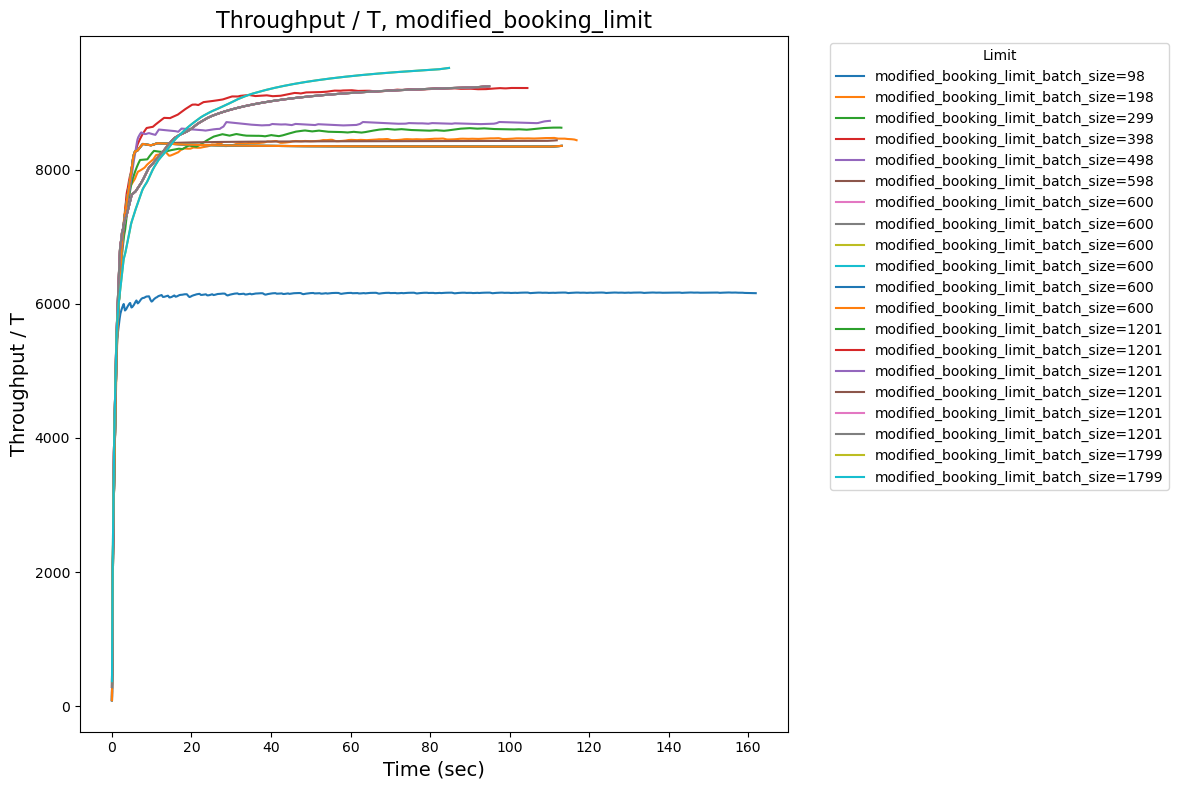

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 指定vllm文件夹的路径
vllm_folder = './modified_booking_limit'

# 获取vllm文件夹下所有符合条件的CSV文件
csv_files = [f for f in os.listdir(vllm_folder) if f.startswith('throughput_modified_booking_limit_limit_') and f.endswith('.csv')]

# 按照batch_size从小到大排序
csv_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# 创建一个新的图表
plt.figure(figsize=(12, 8))

# 遍历每个CSV文件
for file in csv_files:
    # 从文件名中提取batch_size
    batch_size = file.split('_')[-1].split('.')[0]
    
    # 使用pandas读取CSV文件
    file_path = os.path.join(vllm_folder, file)
    df = pd.read_csv(file_path)
    
    # 计算 T时刻的throughput / T
    df['throughput_per_T'] = df['throughput'] / df['Time (sec)']
    
    # 绘制throughput_per_T随时间变化的曲线
    plt.plot(df['Time (sec)'], df['throughput_per_T'], label=f'modified_booking_limit_batch_size={batch_size}')

# 添加图例
plt.legend(title='Limit', bbox_to_anchor=(1.05, 1), loc='upper left')

# 添加标题和标签
plt.title('Throughput / T, modified_booking_limit', fontsize=16)
plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('Throughput / T', fontsize=14)

# 调整布局，防止图例遮挡
plt.tight_layout()

# 显示图表
plt.show()

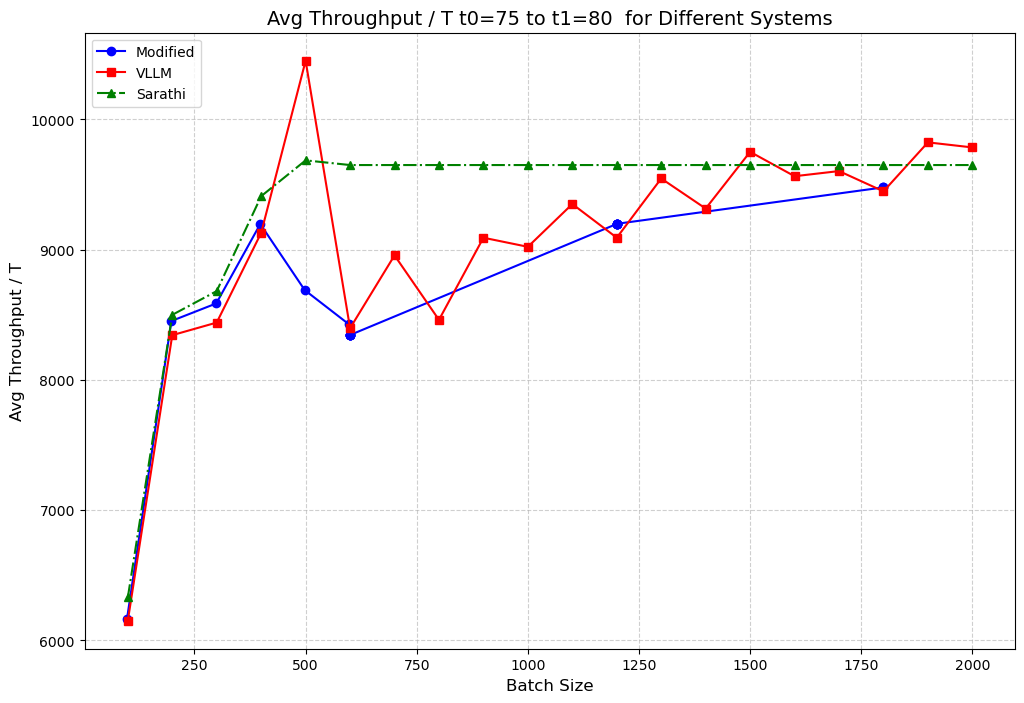

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 指定文件夹的路径
folder_info = [
    {
        'name': 'Modified',
        'path': './modified_booking_limit',
        'pattern': 'throughput_modified_booking_limit_limit_*.csv',
        'key': 'Limit'
    },
    {
        'name': 'VLLM',
        'path': './vllm',
        'pattern': 'throughput_vllm_batch_size_*.csv',
        'key': 'batch_size'
    },
    {
        'name': 'Sarathi',
        'path': './sarathi',
        'pattern': 'throughput_sarathi_batch_size_*.csv',
        'key': 'batch_size'
    },
]

# 设置 t0 的值
t0 = 75  # 你可以修改为合适的时间点
t1 = 80

# 存储所有数据
all_data = {
    'batch_sizes': {},  # 用于存储 batch_size 和对应的 throughput_per_T 平均值
    'mean_throughputs': {},
    'labels': []
}

# 定义函数用于提取 batch_size
def extract_batch_size(file_name, pattern, key):
    try:
        if pattern.startswith('throughput_modified_booking_limit_limit_'):
            # Split the file name and extract the last part before .csv
            parts = file_name.split('_')
            batch_size = int(parts[-1].split('.')[0])
            return batch_size
        elif pattern.startswith('throughput_general_nested_booking_limit_limit_'):
            # Split the file name and extract the last part before .csv
            parts = file_name.split('_')
            batch_size = int(parts[-1].split('.')[0])
            return batch_size
        elif 'batch_size' in pattern:
            # Split the file name using '_batch_size_'
            parts = file_name.split('_batch_size_')
            if len(parts) >= 2:
                batch_part = parts[-1].split('.')[0]
                return int(batch_part)
        return None
    except ValueError:
        return None

# 遍历每个文件夹
for info in folder_info:
    folder_name = info['name']
    folder_path = info['path']
    pattern = info['pattern']
    
    # 获取符合条件的CSV文件
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    csv_files = [f for f in csv_files if f.startswith(pattern.split('*')[0])]
    
    # 提取并过滤有效的 batch_size 和文件
    batch_sizes = []
    valid_csv_files = []
    for f in csv_files:
        batch_size = extract_batch_size(f, pattern, info['key'])
        if batch_size is not None:
            valid_csv_files.append(f)
            batch_sizes.append(batch_size)
    
    # 按照 batch_size 从小到大排序
    valid_csv_files = [file for _, file in sorted(zip(batch_sizes, valid_csv_files))]
    sorted_batch_sizes = sorted(batch_sizes)
    
    # 重新复制排序后的 batch_sizes
    sorted_batch_sizes = []
    for file in valid_csv_files:
        batch_size = extract_batch_size(file, pattern, info['key'])
        sorted_batch_sizes.append(batch_size)
    
    # 存储 batch_size 和对应的 throughput_per_T 平均值
    average_throughput_per_T = []
    
    # 遍历每个CSV文件
    for idx, file in enumerate(valid_csv_files):
        batch_size = sorted_batch_sizes[idx]
        
        # 使用 pandas 读取 CSV 文件
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        
        # 检查列是否存在，如 'throughput' 和 'Time (sec)'
        if 'throughput' not in df.columns or 'Time (sec)' not in df.columns:
            print(f"文件 {file} 缺少必要的列（'throughput' 或 'Time (sec)），跳过此文件")
            continue
        
        # 计算 throughput_per_T
        if df['Time (sec)'].isnull().all() or df['throughput'].isnull().all():
            print(f"文件 {file} 的 'Time (sec)' 或 'throughput' 列包含无效值，跳过此文件")
            continue
        df['throughput_per_T'] = df['throughput'] / df['Time (sec)']
        
        # 过滤出 t >= t0 的数据
        df_filtered = df[(df['Time (sec)'] >= t0) & (df['Time (sec)'] <= t1)]
        
        # 确保没有 NaN 或 0 数据
        df_filtered = df_filtered[df_filtered['throughput_per_T'].notnull() & (df_filtered['throughput_per_T'] > 0)]
        
        # 计算 t0 之后 throughput_per_T 的平均值
        avg_throughput = df_filtered['throughput_per_T'].mean()
        
        # 存储 batch_size 和 平均值
        average_throughput_per_T.append(avg_throughput)
    
    # 存储数据
    all_data['batch_sizes'][folder_name] = sorted_batch_sizes
    all_data['mean_throughputs'][folder_name] = average_throughput_per_T
    all_data['labels'].append(folder_name)

# 创建折线图
plt.figure(figsize=(12, 8))

# 绘制每组数据
for folder_name in all_data['batch_sizes']:
    batch_sizes = all_data['batch_sizes'][folder_name]
    throughputs = all_data['mean_throughputs'][folder_name]
    
    # 确保通过数据有效（避免曲线过短）
    if len(batch_sizes) >= 2 and len(throughputs) >= 2:
        # 选择不同的颜色和标记
        if folder_name == 'Modified':
            plt.plot(batch_sizes, throughputs, marker='o', linestyle='-', color='b', label=folder_name)
        elif folder_name == 'VLLM':
            plt.plot(batch_sizes, throughputs, marker='s', linestyle='-', color='r', label=folder_name)
        elif folder_name == 'Sarathi':
            plt.plot(batch_sizes, throughputs, marker='^', linestyle='-.', color='g', label=folder_name)

# 添加标题和标签
plt.title(f'Avg Throughput / T t0={t0} to t1={t1}  for Different Systems', fontsize=14)
plt.xlabel('Batch Size', fontsize=12)  # 横轴改为 Batch Size
plt.ylabel('Avg Throughput / T', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left')  # 调整图例位置

# 显示图表
plt.show()